### Diabetic Retina Pathology 
##### Imports

In [4]:
from __future__ import absolute_import, division, print_function
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
print("GPU Available: ", tf.test.is_gpu_available())


GPU Available:  True


## If Training on a GPU enabled machine, use the following imports

In [6]:
gpus = tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [7]:
print(os.listdir("./retina_741_data/"))

['resized_train', 'resized_train_cropped', '.ipynb_checkpoints', 'trainLabels_cropped.csv', 'trainLabels.csv']


# Data Prep

In [8]:
path = "./retina_741_data/resized_train_cropped/resized_train_cropped"

In [9]:
#os.mkdir("../output/kaggle/working/train")

In [10]:
data = "./retina_741_data/resized_train_cropped/resized_train_cropped/"
print('number of images in total - ',len(os.listdir(data)))

number of images in total -  35108


In [11]:
index = pd.read_csv("./retina_741_data/trainLabels_cropped.csv") 
print('number of images in total - ',len(index))
index.head(10)

number of images in total -  35108


,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
5,5,5,15_right,2
6,6,6,16_left,4
7,7,7,16_right,4
8,8,8,17_left,0
9,9,9,17_right,1


# Data Visualization

In [12]:
#format correctly
index['image_name'] = [i+".jpeg" for i in index['image'].values]
index['level_binary'] = [i for i in index['level'].values]

for i in range(len(index.level)):
    if index['level'][i] == 0:
        index['level_binary'][i] = 0
    else:
        index['level_binary'][i] = 1
    
index.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Unnamed: 0,Unnamed: 0.1,image,level,image_name,level_binary
0,0,0,10_left,0,10_left.jpeg,0
1,1,1,10_right,0,10_right.jpeg,0
2,2,2,13_left,0,13_left.jpeg,0
3,3,3,13_right,0,13_right.jpeg,0
4,4,4,15_left,1,15_left.jpeg,1
5,5,5,15_right,2,15_right.jpeg,1
6,6,6,16_left,4,16_left.jpeg,1
7,7,7,16_right,4,16_right.jpeg,1
8,8,8,17_left,0,17_left.jpeg,0
9,9,9,17_right,1,17_right.jpeg,1


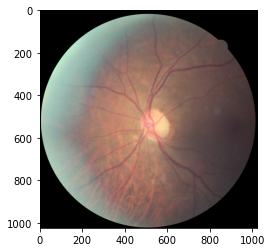

In [13]:
temp = path + '/10_left' + '.jpeg'

plt.imshow(plt.imread(temp))
#plt.imshow(plt.imread("../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/43233_left.jpeg"))

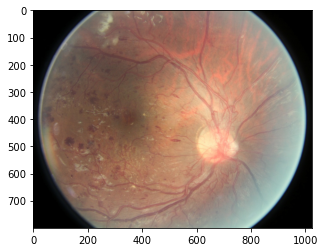

In [14]:
temp = path + '/16_left' + '.jpeg'

plt.imshow(plt.imread(temp))

0    25802
1     9306
Name: level_binary, dtype: int64

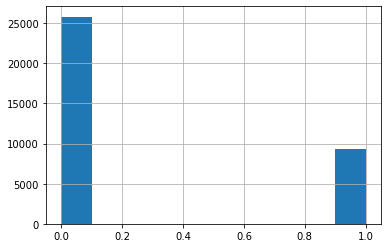

In [15]:
index['level_binary'].hist()
index['level_binary'].value_counts()

# Batch Generation

In [16]:
train1, val = train_test_split(index, test_size=0.2)
train, test = train_test_split(train1, test_size=0.25)
#80/20/20 split

(29841,) (29841,) (5267,) (5267,)
16555    20789_right
15364     19254_left
25171    31891_right
27959    35428_right
24832     31428_left
            ...     
33333     42129_left
2449       3031_left
10566    13300_right
7758       9761_left
13599     17088_left
Name: image, Length: 29841, dtype: object
       Unnamed: 0  Unnamed: 0.1        image  level        image_name  \
19867       19867         19879  25073_right      0  25073_right.jpeg   
30178       30178         30194   38196_left      2   38196_left.jpeg   
6727         6727          6731   8469_right      0   8469_right.jpeg   
26769       26769         26784   33889_left      1   33889_left.jpeg   
32480       32480         32496   41020_left      2   41020_left.jpeg   
...           ...           ...          ...    ...               ...   
15275       15275         15285  19141_right      1  19141_right.jpeg   
679           679           680     831_left      0     831_left.jpeg   
29261       29261         29277  370

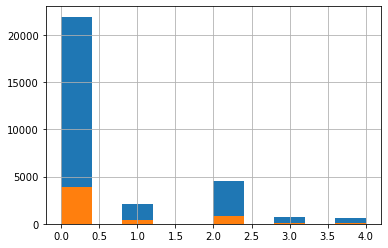

In [17]:
x = index['image']
y = index['level']
#x,y = shuffle(x,y)

train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.15,stratify=y)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()
print(train_x)
print(train)

(21064, 6) (7022, 6) (7022, 6)


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'Unnamed: 0.1'}>],
       [<AxesSubplot:title={'center':'level'}>,
        <AxesSubplot:title={'center':'level_binary'}>]], dtype=object)

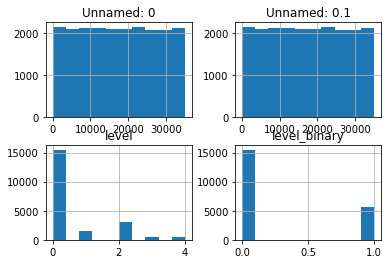

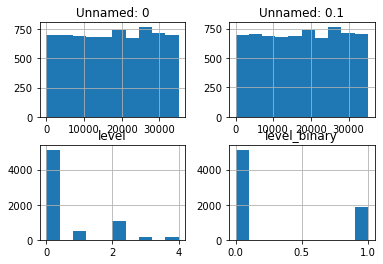

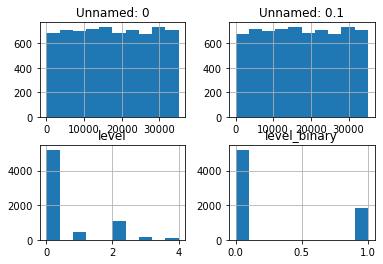

In [18]:
print(train.shape, val.shape, test.shape)
train.hist()
val.hist()
test.hist()

In [19]:
train_datagen = ImageDataGenerator(rescale            = 1/255,
                                   shear_range        = 0.2,
                                   zoom_range         = 0.2,
                                   horizontal_flip    = True,
                                   rotation_range     = 40,
                                   width_shift_range  = 0.2,
                                   height_shift_range = 0.2)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [20]:
train_set = train_datagen.flow_from_dataframe(
    train,
    "./retina_741_data/resized_train_cropped/resized_train_cropped",
    x_col="image_name",
    y_col="level_binary",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

val_set = test_datagen.flow_from_dataframe(
    val,
    "./retina_741_data/resized_train_cropped/resized_train_cropped",
    x_col="image_name",
    y_col="level_binary",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

test_set = test_datagen.flow_from_dataframe(
    test,
    "./retina_741_data/resized_train_cropped/resized_train_cropped",
    x_col="image_name",
    y_col="level_binary",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

Found 21064 validated image filenames.
Found 7022 validated image filenames.
Found 7022 validated image filenames.


In [21]:
print(train_set)

# Build Model

In [22]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation = 'sigmoid'))

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
x = Dense(256, activation='elu')(x)

predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model.summary()

model_train = model.fit_generator(
    train_set,
    steps_per_epoch = 200,
    epochs = 10,
    validation_data = val_set,
    validation_steps = 100)

for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

Using TensorFlow backend.


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
200/200 [==============================] - 179s 894ms/step - loss: 0.6750 - accuracy: 0.7139 - val_loss: 0.5640 - val_accuracy: 0.7394
Epoch 2/10
200/200 [==============================] - 178s 892ms/step - loss: 0.5831 - accuracy: 0.7291 - val_loss: 0.5885 - val_accuracy: 0.7394
Epoch 3/10
200/200 [==============================] - 178s 889ms/step - loss: 0.5655 - accuracy: 0.7414 - val_loss: 0.5569 - val_accuracy: 0.7375
Epoch 4/10
200/200 [==============================] - 177s 884ms/step - loss: 0.5724 - accuracy: 0.7287 - val_loss: 0.5667 - val_accuracy: 0.7337
Epoch 5/10
200/200 [==============================] - 177s 885ms/step - loss: 0.5613 - accuracy: 0.7422 - val_loss: 0.5460 - val_accuracy: 0.7450
Epoch 6/10
200/200 [==============================] - 177s 883ms/step - loss: 0.5482 - accuracy: 0.7491 - val_loss: 0.5560 - val_accuracy: 0.7378
Epoch 7/10
200/200 [============================

In [23]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Train Model

In [ ]:
model_train = model.fit_generator(
    train_set,
    steps_per_epoch = 200,
    epochs = 10,
    validation_data = val_set,
    validation_steps = 100)

Epoch 1/10
200/200 [==============================] - 178s 890ms/step - loss: 0.5757 - accuracy: 0.7350 - val_loss: 0.5519 - val_accuracy: 0.7497
Epoch 2/10
 13/200 [>.............................] - ETA: 1:56 - loss: 0.5420 - accuracy: 0.7524

In [ ]:
#plt.plot(model_train.history['acc'])
#plt.plot(model_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'var'], loc='best')
plt.show()

plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'var'], loc='best')
plt.show()

# Test Some Images

In [ ]:
from PIL import Image
im = Image.open("../input/diabetic-retinopathy-resized/resized_train/resized_train/" + val.iloc[0].image_name)
im = np.array(im.resize((224, )*2, resample=Image.LANCZOS))
im.shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [ ]:
import cv2

testimage = cv2.resize(im, (224,224))
testimage = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),10) ,-4 ,128) 

print("predicted:", np.argmax(model.predict(testimage.reshape(1, *im.shape))[0]))
print("actual:", val.iloc[0].level)